In [17]:
import os
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import pysm3
import pysm3.units as u
from fgbuster import (CMB, Dust, Synchrotron,
                      basic_comp_sep,harmonic_ilc,
                      get_observation, get_instrument, MixingMatrix)

from noise import S4_LAT
from misc import camb_clfile

In [2]:
NSIDE=1024
sky = pysm3.Sky(nside=NSIDE, preset_strings=["c1"])

/global/homes/l/lonappan/.conda/envs/PC2/lib/python3.7/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /global/project/projectdirs/cmb/www/pysm-data/pysm_2/camb_lenspotentialCls.dat
  warnings.warn(f"Access data from {full_path}")
/global/homes/l/lonappan/.conda/envs/PC2/lib/python3.7/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /global/project/projectdirs/cmb/www/pysm-data/pysm_2/delens_ells.txt
  warnings.warn(f"Access data from {full_path}")


In [18]:
cl_len = camb_clfile("/global/cscratch1/sd/lonappan/S4BIRD/CAMB/BBSims_lensed_dls.dat")

In [3]:
noise = S4_LAT()
Nl_T= noise.noise_curves_T()
Nl_P= noise.noise_curves_P()

/global/u2/l/lonappan/workspace/s4bird/cmbs4_noise/noise.py:155: RuntimeWarning: divide by zero encountered in power
  ellf = (ell/self.Tatmos_ell[:,None])**(self.Tatmos_alpha[:,None])
/global/u2/l/lonappan/workspace/s4bird/cmbs4_noise/noise.py:156: RuntimeWarning: invalid value encountered in multiply
  T_noise = self.Tatmos_cov[:,:,None] * (ellf[:,None,:] * ellf[None,:,:])**.5
/global/u2/l/lonappan/workspace/s4bird/cmbs4_noise/noise.py:159: RuntimeWarning: divide by zero encountered in power
  P_low_noise = (2*W[:,None]) * (ell / self.Patmos_ell[:,None])**self.Patmos_alpha[:,None]
/global/u2/l/lonappan/workspace/s4bird/cmbs4_noise/noise.py:161: RuntimeWarning: invalid value encountered in multiply
  (P_low_noise[:,None,:] * P_low_noise[None,:,:])**.5)


In [4]:
nlevt = noise.white_noise_level_T()
nlevp = noise.white_noise_level_P()

In [5]:
def get_noise_map(nside,depth_i,depth_p):
    n_pix = hp.nside2npix(nside)
    res = np.random.normal(size=(n_pix, 3))
    depth = np.stack((depth_i, depth_p, depth_p))
    depth *= u.arcmin * u.uK_CMB
    depth = depth.to(getattr(u, 'uK_CMB') * u.arcmin,equivalencies=u.cmb_equivalencies(0 * u.GHz))
    res *= depth.value / hp.nside2resol(nside, True)
    return  res.T

In [6]:
bands = noise.bands
beams = noise.beams
maps_array = []
for idx in range(len(bands)):
    print(idx)
    maps = sky.get_emission(bands[idx]* u.GHz)
    maps= maps.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(bands[idx]*u.GHz))

    #just to remove 'inf' 
    #Nl_T[idx][0] = 0
    #Nl_P[idx][0] = 0
    #Nl_P[idx][0] = 0
    
    #noiseI = hp.synfast(Nl_T[idx],nside=NSIDE)
    #noiseQ = hp.synfast(Nl_P[idx],nside=NSIDE)
    #noiseU = hp.synfast(Nl_P[idx],nside=NSIDE)

    maps_beam = hp.smoothing(maps.value,fwhm=np.radians(beams[idx]/60),pol=True)
    maps_noise = get_noise_map(NSIDE,nlevt[idx],nlevp[idx])
    maps_array.append(maps_beam+maps_noise)
    #maps_array.append(np.array([maps_beam[0]+noiseI,maps_beam[1]+noiseQ,maps_beam[2]+noiseU]))

0
1
2
3
4
5
6


In [7]:
components = [CMB()]

In [8]:
class make_experiment:
    def __init__(self,bands,beams):
        self.frequency = bands
        self.fwhm = beams

In [9]:
inst = make_experiment(bands,beams)

In [10]:
bins = np.arange(1000) * 10
result = harmonic_ilc(components, inst, np.array(maps_array),bins)

In [11]:
tW = np.squeeze(result.W[0])

In [12]:
lastidx = len(tW)
tN = np.zeros(lastidx)
for idx in range(len(bands)):
    tN += tW[:,idx]**2 * Nl_T[idx][:lastidx]

Text(0, 0.5, '$N_\\ell^T$')

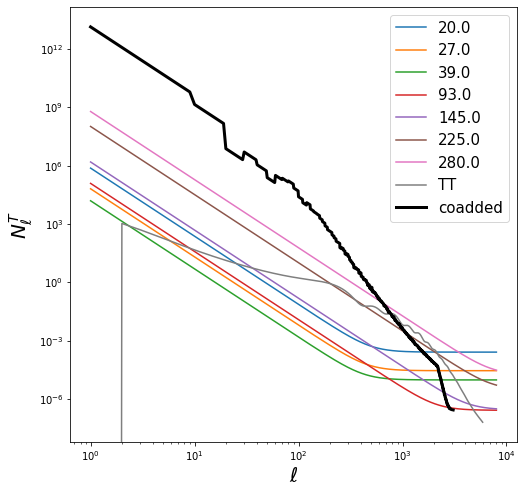

In [28]:
plt.figure(figsize=(8,8))
for idx in range(len(bands)):
    plt.loglog(Nl_T[idx],label=bands[idx])
plt.loglog(np.arange(len(cl_len['tt'])),cl_len['tt'],label='TT')
plt.loglog(tN,c='k',lw=3,label="coadded")
plt.legend(fontsize=15)
plt.xlabel("$\ell$",fontsize=20)
plt.ylabel("$N_\ell^T$",fontsize=20)

In [14]:
pW = np.squeeze(result.W[1])
pN = np.zeros(lastidx)
for idx in range(len(bands)):
    pN += pW[:,idx]**2 *Nl_P[idx][:lastidx]

Text(0, 0.5, '$N_\\ell^P$')

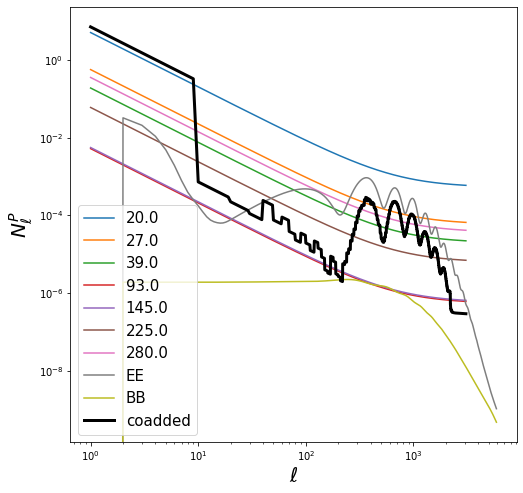

In [27]:
plt.figure(figsize=(8,8))
for idx in range(len(bands)):
    plt.loglog(Nl_P[idx][:lastidx],label=bands[idx])
plt.loglog(np.arange(len(cl_len['bb'])),cl_len['ee'],label='EE')
plt.loglog(np.arange(len(cl_len['bb'])),cl_len['bb'],label='BB')
plt.loglog(pN,c='k',lw=3,label="coadded")
plt.legend(fontsize=15)
plt.xlabel("$\ell$",fontsize=20)
plt.ylabel("$N_\ell^P$",fontsize=20)

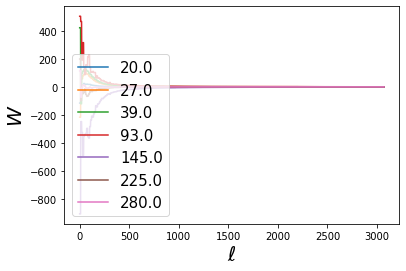

In [16]:
for idx in range(len(bands)):
    plt.plot(tW[:,idx],label=bands[idx])

plt.xlabel("$\ell$",fontsize=20)
plt.ylabel("$W$",fontsize=20)
plt.legend(fontsize=15)